In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

Read in data to generate Pandas dataframe. If generating for the first time, will take about five minutes. Otherwise, it should take about 10 seconds.

In [2]:
datapath = '../data/Pose_Dataset/'
nFrames = 300 # number of frames per squat
df_filename = '../data/all-data.pkl' # where to save concatenated data
np_filename = '../data/np-data.npy'
name_to_label = {
    'bad_innner_thigh': 0,
    'bad_back_round': 1,
    'bad_back_warp': 2,
    'bad_head': 3,
    'bad_shallow': 4,
    'bad_toe': 5,
    'good': 6
}

if os.path.exists(df_filename) and os.path.exists(np_filename):
    # read in pkl file
    df = pd.read_pickle(df_filename)
    with open(np_filename, 'rb') as f:
        X_train = np.load(f)
        y_train = np.load(f)
        X_val = np.load(f)
        y_val = np.load(f)
        X_test = np.load(f)
        y_test = np.load(f)
else:
    # generate pkl file and npy file

    # initialize arrays to fill in each loop iteration
    filenames = []
    datas = []
    np_datas = []
    labels = []

    # read in each squat file
    for cur_dir, _, files in os.walk(datapath):
        for file in files:
            if not file.endswith('.json'):
                continue
            filename = os.path.join(cur_dir, file)
            filenames.append(filename)

            data = pd.read_json(filename).to_numpy()
            data = data[1,0:nFrames] # get data for frames. Note some files have 301 frames, truncate all to first 300
            datas.append(data)
            np_data = np.array([np.array(d) for d in data])
            if np_data.shape == (300, 171):
                np_datas.append(np_data)
            labels.append(name_to_label[cur_dir.split('/')[-2]])
        print(f"Done processing {cur_dir}")

    # move arrays into dataframe
    datas = np.array(datas) # convert to array so we can loop through
    d = {'filename': filenames}
    for i in range(nFrames):
        d[str(i)] = datas[:,i]
    df = pd.DataFrame(data=d)

    # save to pkl
    df.to_pickle(df_filename)

    # write data into numpy arrays and save
    np_datas = np.stack(np_datas)
    labels = np.array(labels)

    n = np_datas.shape[0]
    split_indices = [int(n * 0.8), int(n * 0.9)]
    train_indices, val_indices, test_indices = np.split(np.random.choice(n, n, replace=False), split_indices)

    X_train = np_datas[train_indices]
    y_train = labels[train_indices]

    X_val = np_datas[val_indices]
    y_val = labels[val_indices]

    X_test = np_datas[test_indices]
    y_test = labels[test_indices]
    
    with open(np_filename, 'wb') as f:
        np.save(f, X_train)
        np.save(f, y_train)
        np.save(f, X_val)
        np.save(f, y_val)
        np.save(f, X_test)
        np.save(f, y_test)

Add label column based on filename

In [3]:
df['label'] = [df['filename'][i].split('/')[3] for i in range(len(df))]

Print out the first five rows of the dataframe. The 'filename' column contains full filepath + name of each squat, and the remaining columns contain pose data for each of 300 frames.

In [4]:
df.head(5)

,filename,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,label
0,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.43120177353718403, 0.797377414334803, 0.844...","[0.430941564889928, 0.79869170732256, 0.847091...","[0.431044555308539, 0.799997781067416, 0.84760...","[0.431592316178638, 0.7988144430510611, 0.8469...","[0.4311132590348, 0.7942079960716251, 0.840107...","[0.43193753462167306, 0.7949407220012981, 0.84...","[0.432750845147567, 0.7839057041264701, 0.8325...","[0.432541413484046, 0.787418809894588, 0.83614...","[0.431894497467298, 0.786059366307652, 0.83555...",...,"[0.43357581090852304, 0.7943466004531391, 0.84...","[0.433069769111656, 0.7938311318961081, 0.8431...","[0.431030331629899, 0.786474443905499, 0.83585...","[0.43115121328079503, 0.7842615868752231, 0.83...","[0.43390441871996305, 0.7924671389584511, 0.84...","[0.43198091643781905, 0.7867065528136351, 0.83...","[0.43174849778878904, 0.783046079262931, 0.836...","[0.43123957336803503, 0.787923224200576, 0.840...","[0.428997741451614, 0.780915252148985, 0.83353...",good
1,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.47551463277682005, 0.9215836428119221, 0.93...","[0.47563254721491705, 0.9217684412264681, 0.93...","[0.47606479372639904, 0.921504059759201, 0.932...","[0.476369782218, 0.920659233360356, 0.93398515...","[0.474865629960791, 0.9185499246891451, 0.9351...","[0.47621913132710003, 0.9194576930028691, 0.93...","[0.47541189727106403, 0.916291807802979, 0.935...","[0.473958178841594, 0.9117857030781501, 0.9319...","[0.47338005686455703, 0.907825476525932, 0.933...",...,"[0.43516232461652304, 0.7482315863841671, 0.81...","[0.440398428175206, 0.771004741367683, 0.83682...","[0.45157124879577604, 0.815575642811675, 0.875...","[0.456352779376737, 0.843149297107819, 0.90124...","[0.464314572629178, 0.8598558365912851, 0.9082...","[0.46697763869442105, 0.8769539497506571, 0.92...","[0.46801772225950805, 0.8857252811475381, 0.92...","[0.468906910070493, 0.89422190287234, 0.928794...","[0.47246470516002803, 0.9024032699077711, 0.93...",good
2,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.487507568770135, 0.945001119666321, 0.95042...","[0.48724964719018404, 0.9447277868278361, 0.94...","[0.48733040533680005, 0.9444814068387251, 0.95...","[0.487969080175346, 0.946172353218329, 0.95415...","[0.48801193176894003, 0.946446475083851, 0.954...","[0.48742002510173404, 0.9443007012276421, 0.95...","[0.48699883703371705, 0.944366404361722, 0.957...","[0.48672516046768005, 0.9434340433389351, 0.95...","[0.48594678261619706, 0.9419660089707981, 0.95...",...,"[0.48502701306215, 0.9386721636737401, 0.95784...","[0.48510789168053, 0.9385537482653441, 0.95760...","[0.48517004926523405, 0.9378531640723361, 0.95...","[0.485991932994121, 0.9392084318376931, 0.9576...","[0.48617870299984006, 0.9400844966051861, 0.95...","[0.48613420586339506, 0.939901991724413, 0.950...","[0.48738268976887006, 0.9421225640340241, 0.95...","[0.487048790933767, 0.941068299266387, 0.94779...","[0.48686638446639, 0.9400423518104981, 0.94476...",good
3,../data/Pose_Dataset/good/1115_3djoints_index/...,"[0.47153572199932403, 0.857707360049973, 0.912...","[0.47160060745792703, 0.8573000747132821, 0.91...","[0.47036495298267605, 0.8531030652053331, 0.90...","[0.47240727772132, 0.860811007425445, 0.915781...","[0.46991840338782903, 0.8573401020290371, 0.91...","[0.47183890308743204, 0.8578533481614711, 0.91...","[0.469546441113654, 0.85047357179348, 0.904737...","[0.472174902614971, 0.854945950506319, 0.91187...","[0.46757983379684404, 0.8449749239116151, 0.90...",...,"[0.39646774404282203, 0.6211367265235841, 0.68...","[0.401195957721987, 0.6348000804749631, 0.7068...","[0.40244821179802404, 0.6407111917934291, 0.71...","[0.40574182411201004, 0.6531848616857611, 0.72...","[0.40859117574242604, 0.6741368173148691, 0.74...","[0.409277574312078, 0.6778921720769541, 0.7455...","[0.409182634792002, 0.682084981652292, 0.75031...","[0.412567976505038, 0.69516563040747, 0.759781

In [5]:
labels = df.label.unique()
for label in labels:
    print('%s: %i' %(label,sum(df['label']==label)))

nClasses = 7

print('\n Train')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_train==i)))

print('\n Val')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_val==i)))

print('\n Test')
labels = df.label.unique()
for i in range(nClasses):
    print('%s: %i' %(i,sum(y_test==i)))

good: 293
bad_toe: 295
bad_shallow: 319
bad_innner_thigh: 230
bad_back_round: 280
bad_back_warp: 312
bad_head: 272

 Train
0: 177
1: 227
2: 252
3: 221
4: 249
5: 242
6: 232

 Val
0: 34
1: 28
2: 30
3: 23
4: 28
5: 25
6: 32

 Test
0: 19
1: 25
2: 30
3: 27
4: 42
5: 28
6: 29


In [6]:
# # TODO remove this in future
# mask = (y_train == 6) | (y_train == 1)

# X_train = X_train[mask]
# y_train = y_train[mask]
# y_train = np.where(y_train != 6, 0, 1)

# mask = (y_val == 6) | (y_val == 1)

# X_val = X_val[mask]
# y_val = y_val[mask]
# y_val = np.where(y_val != 6, 0, 1)

# # y_test = np.where(y_test != 6, 0, 1)

# print(np.sum(y_train) / np.size(y_train))
# print(y_train.shape)
print(y_train)

[5 1 1 ... 6 3 6]


In [7]:
# one-hot y values # REMEMBER TO ONLY RUN THIS ONCE
y_train_onehot = tf.keras.utils.to_categorical(y_train,num_classes=nClasses)
y_val_onehot = tf.keras.utils.to_categorical(y_val,num_classes=nClasses)
y_test_onehot = tf.keras.utils.to_categorical(y_test,num_classes=nClasses)

In [8]:
model_input = tf.keras.Input(shape=(300,171))
print(model_input.shape)

# first conv layer
x = tf.keras.layers.Conv1D(256,3,strides=2,padding='same')(model_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
print(x.shape)

# res layers
nResLayers = 4

for i in range(nResLayers):
    y = tf.keras.layers.Conv1D(256,3,strides=2,padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    y = tf.keras.layers.Conv1D(256,3,strides=1,padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    y = tf.keras.layers.Conv1D(256,3,strides=1,padding='same')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation('relu')(y)

    z = tf.keras.layers.Conv1D(256,1,strides=2,padding='same')(x)
    z = tf.keras.layers.BatchNormalization()(z)
    
    x = tf.keras.layers.add([y,z])
    print(x.shape)

# adaptive average pool
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Reshape((256,))(x)
# # final conv layer
# model_output = tf.keras.layers.Conv1D(2,1,strides=1)(x)
model_output = tf.keras.layers.Dense(nClasses, activation='softmax')(x)
        
model = tf.keras.Model(model_input, model_output, name="ogata_model")
model.summary()

(None, 300, 171)
(None, 150, 256)
(None, 75, 256)
(None, 38, 256)
(None, 19, 256)
(None, 10, 256)
Model: "ogata_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 171)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 150, 256)     131584      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 256)     1024        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 150, 256)     0           batch_normalization[0][0

In [9]:
BATCH_SIZE = 16
opt = tf.keras.optimizers.Adadelta(learning_rate = 0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train_dset = tf.data.Dataset.from_tensor_slices((X_train,y_train_onehot)).batch(BATCH_SIZE)
val_dset = tf.data.Dataset.from_tensor_slices((X_val,y_val_onehot)).batch(BATCH_SIZE)
test_dset = tf.data.Dataset.from_tensor_slices((X_test,y_test_onehot)).batch(BATCH_SIZE)

In [10]:
history = model.fit(train_dset,epochs=30,validation_data = val_dset)

Epoch 1/30
100/100 [==============================] - 3s 26ms/step - loss: 1.9628 - accuracy: 0.2688 - val_loss: 2.0411 - val_accuracy: 0.1350
Epoch 2/30
100/100 [==============================] - 2s 21ms/step - loss: 1.3692 - accuracy: 0.4863 - val_loss: 2.3305 - val_accuracy: 0.1400
Epoch 3/30
100/100 [==============================] - 2s 20ms/step - loss: 1.0939 - accuracy: 0.6388 - val_loss: 2.3152 - val_accuracy: 0.1700
Epoch 4/30
100/100 [==============================] - 2s 20ms/step - loss: 0.9121 - accuracy: 0.7306 - val_loss: 1.7743 - val_accuracy: 0.3250
Epoch 5/30
100/100 [==============================] - 2s 20ms/step - loss: 0.7736 - accuracy: 0.8012 - val_loss: 1.3221 - val_accuracy: 0.4950
Epoch 6/30
100/100 [==============================] - 2s 20ms/step - loss: 0.6607 - accuracy: 0.8625 - val_loss: 1.1421 - val_accuracy: 0.5950
Epoch 7/30
100/100 [==============================] - 2s 20ms/step - loss: 0.5647 - accuracy: 0.9006 - val_loss: 1.1059 - val_accuracy: 0.6150

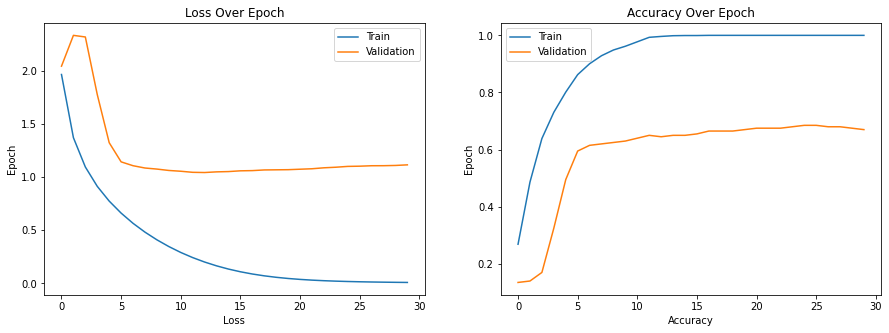

In [11]:
x = np.arange(len(history.history['accuracy']))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Over Epoch")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Over Epoch")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend()
plt.show()

plt.close()

In [17]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

13/13 [==============================] - 0s 9ms/step - loss: 1.0308 - accuracy: 0.7000
Test accuracy: 0.700
